# Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Important libraries
import numpy as np
import pandas as pd
import random

# Models
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# feture selection
from sklearn.feature_selection import SequentialFeatureSelector

# measuring performance
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, make_scorer

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Helper Functions

In [ ]:
#Function to evaluate the performance of the model using classification report and plot the confusion matrix using heatmap
from sklearn.metrics import plot_confusion_matrix
def evaluate_model(model, X_test, y_test, title=''):
  figure, ax = plt.subplots(figsize=(12, 12))
  plot_confusion_matrix(model, X_test, y_test, ax=ax) 
  plt.title(title)
  plt.show()

In [ ]:
def plotModels(models, title = '', xlabel = '', ylabel = ''):
  for i in models:
    plt.bar(i[0], i[1])

  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

# Using The CICIDS2017 dataset (Binary)

## Dataset Preprocessing

In [ ]:
cicids_dataset = pd.read_csv('/content/drive/MyDrive/AI for CS/Final Project Datasets/CICIDS2017.csv', index_col=[0])

In [ ]:
cicids_dataset.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,0
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,0
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,0
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,0


In [ ]:
cicids_dataset = cicids_dataset[(cicids_dataset.iloc[:, :] < np.finfo(np.float64).max).all(axis=1)]

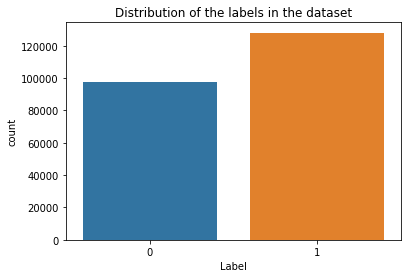

In [ ]:
ax = sns.countplot(x ='Label', data=cicids_dataset)
ax.set_xticklabels(ax.get_xticklabels())
ax.set_title('Distribution of the labels in the dataset')
plt.show()

In [ ]:
cicids_X = cicids_dataset.iloc[:,:-1]
cicids_y = cicids_dataset.iloc[:,-1]

In [ ]:
cicids_X.shape

(225711, 78)

In [ ]:
# scaling the dataset
cicids_scaler = MinMaxScaler()
cicids_scaled = pd.DataFrame(cicids_scaler.fit_transform(cicids_X), columns = cicids_X.columns)

In [ ]:
cicids_scaled.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,0.837225,3.333335e-08,0.000518,0.00000,0.000066,0.000000,0.000514,0.004076,0.001552,0.0,0.000000,0.00000,0.000000,0.0,0.007685,0.533333,3.738318e-08,0.0,3.333333e-08,1.401869e-07,2.500000e-08,2.500000e-08,0.0,2.500000e-08,1.250000e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001015,0.00000,0.222222,0.000000,0.017804,0.000514,0.003098,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.00356,0.001552,0.000000,0.001015,0.0,0.0,0.0,0.0,0.0,0.0,0.000518,0.000066,0.00000,0.000000,0.000519,0.000000,0.000518,0.384615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.840109,9.166671e-07,0.000000,0.00034,0.000033,0.000001,0.000514,0.004076,0.001552,0.0,0.000514,0.00411,0.001034,0.0,0.005817,0.403670,1.028037e-06,0.0,9.166667e-07,1.130841e-06,0.000000e+00,0.000000e+00,0.0,0.000000e+00,9.999999e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000508,0.00034,0.003058,0.004587,0.017804,0.000514,0.003098,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.142857,0.00356,0.001552,0.001034,0.000508,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000033,0.00034,0.000001,0.000458,0.003922,0.000000,0.384615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.840124,4.416669e-07,0.000000,0.00034,0.000033,0.000001,0.000514,0.004076,0.001552,0.0,0.000514,0.00411,0.001034,0.0,0.005875,0.407692,4.953271e-07,0.0,4.416667e-07,5.981308e-07,0.000000e+00,0.000000e+00,0.0,0.000000e+00,9.999999e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000508,0.00034,0.006410,0.009615,0.017804,0.000514,0.003098,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.142857,0.00356,0.001552,0.001034,0.000508,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000033,0.00034,0.000001,0.000458,0.003922,0.000000,0.384615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.705548,2.916668e-07,0.000000,0.00034,0.000033,0.000001,0.000514,0.004076,0.001552,0.0,0.000514,0.00411,0.001034,0.0,0.005933,0.411765,3.271028e-07,0.0,2.916667e-07,4.299065e-07,0.000000e+00,0.000000e+00,0.0,0.000000e+00,9.999999e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000508,0.00034,0.009804,0.014706,0.017804,0.000514,0.003098,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.142857,0.00356,0.001552,0.001034,0.000508,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000033,0.00034,0.000001,0.000488,0.005035,0.000000,0.384615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.837194,3.333335e-08,0.000518,0.00000,0.000066,0.000000,0.000514,0.004076,0.001552,0.0,0.000000,0.00000,0.000000,0.0,0.007685,0.533333,3.738318e-08,0.0,3.333333e-08,1.401869e-07,2.500000e-08,2.500000e-08,0.0,2.500000e-08,1.250000e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001015,0.00000,0.222222,0.000000,0.017804,0.000514,0.003098,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.00356,0.001552,0.000000,0.001015,0.0,0.0,0.0,0.0,0.0,0.0,0.000518,0.000066,0.00000,0.000000,0.000504,0.000000,0.000518,0.3846

In [ ]:
X_train_cicids, X_test_cicids, y_train_cicids, y_test_cicids = train_test_split(cicids_scaled, cicids_y, train_size=0.8, random_state=42, stratify=cicids_y)
X_train_cicids, X_val_cicids, y_train_cicids, y_val_cicids = train_test_split(X_train_cicids, y_train_cicids, train_size=0.9, random_state=42, stratify=y_train_cicids)


## Testing all features on the models

In [ ]:
cicids_fs_before = []

### MLPClassifier

In [ ]:
parameter_space = {
    'hidden_layer_sizes': [(100,200),(100,)],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05]
}

mlp_clf = MLPClassifier(random_state = 42, max_iter = 100)
# Build the grid search
grid_MLP = GridSearchCV(estimator=mlp_clf, param_grid=parameter_space, cv = 5, n_jobs=-1)
grid_results = grid_MLP.fit(X_val_cicids, y_val_cicids)

grid_results.best_params_, grid_results.best_score_

({'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'solver': 'adam'},
 0.9989477825998019)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19538
           1       1.00      1.00      1.00     25605

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143



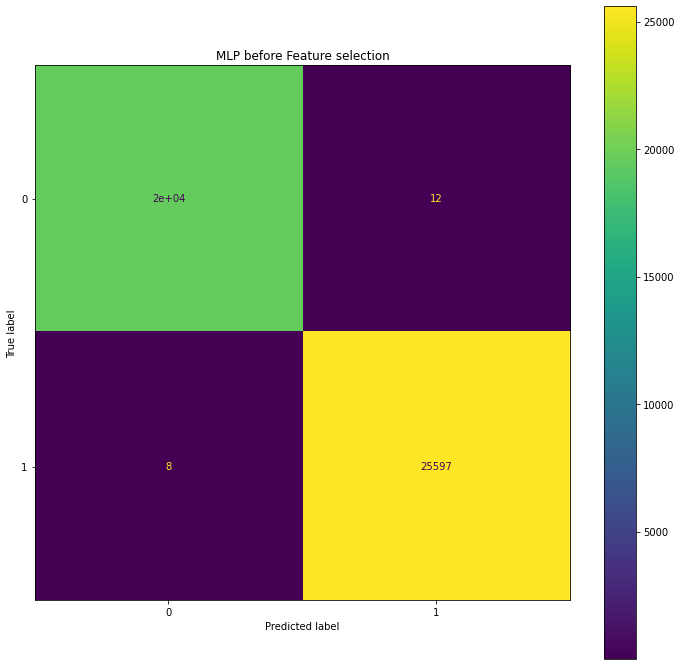

In [ ]:
# first the mlp classifier

mlp_clf = MLPClassifier(random_state = 42, max_iter = 100, hidden_layer_sizes = (100, ), alpha= 0.0001, solver='adam')

mlp_clf.fit(X_train_cicids, y_train_cicids)

y_pred = mlp_clf.predict(X_test_cicids)

print(classification_report(y_test_cicids, y_pred))

F1_mlp = f1_score(y_test_cicids, y_pred)

cicids_fs_before.append(['MLP', F1_mlp])

evaluate_model(mlp_clf, X_test_cicids, y_test_cicids, 'MLP before Feature selection')

              precision    recall  f1-score   support

           0       0.83      0.93      0.87     19538
           1       0.94      0.85      0.89     25605

    accuracy                           0.89     45143
   macro avg       0.88      0.89      0.88     45143
weighted avg       0.89      0.89      0.89     45143



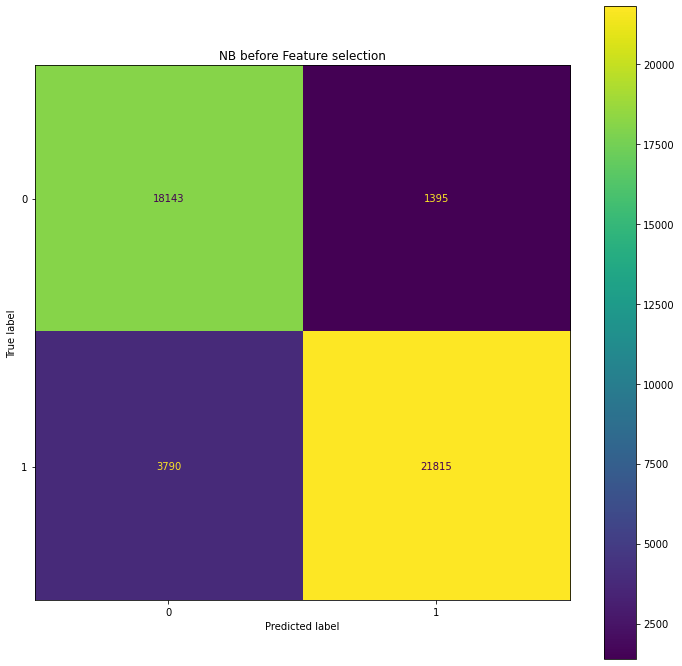

In [ ]:
# second the multinomial naive bayes

nb_clf = MultinomialNB()

nb_clf.fit(X_train_cicids, y_train_cicids)

y_pred = nb_clf.predict(X_test_cicids)

print(classification_report(y_test_cicids, y_pred))


evaluate_model(nb_clf, X_test_cicids, y_test_cicids, 'NB before Feature selection')

F1_NB = f1_score(y_test_cicids, y_pred)

cicids_fs_before.append(['NB', F1_NB])

In [ ]:
param_grid = {'C': [0.1,1, 10, 100], 
              'gamma': [1,0.1,0.01,0.001]}

svm_clf = SVC(random_state = 42)
# Build the grid search
grid_svm = GridSearchCV(estimator=svm_clf, param_grid=param_grid, cv = 5, n_jobs=-1)
grid_results = grid_svm.fit(X_val_cicids, y_val_cicids)

grid_results.best_params_, grid_results.best_score_

({'C': 100, 'gamma': 1}, 0.9936868949404933)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19538
           1       1.00      1.00      1.00     25605

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143



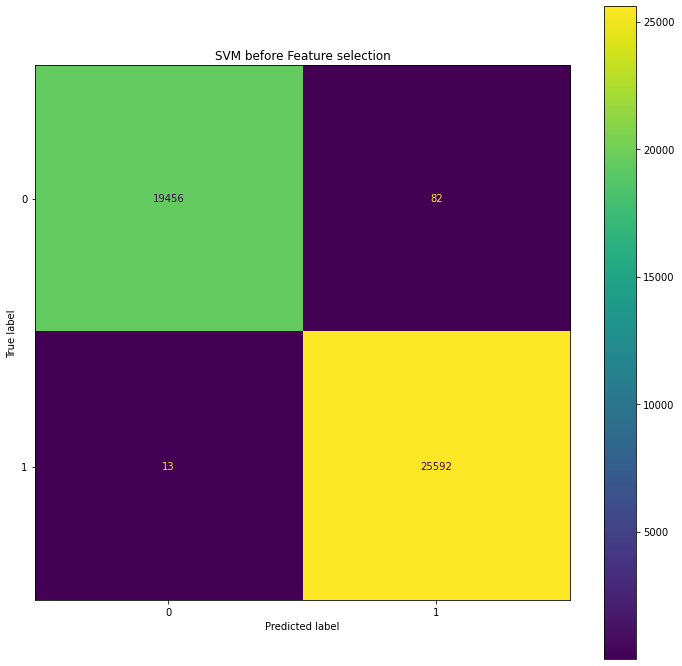

In [ ]:
# third the SVM model

svm_clf = SVC(random_state = 42, C=100, gamma=1)

svm_clf.fit(X_train_cicids, y_train_cicids)

y_pred = svm_clf.predict(X_test_cicids)

print(classification_report(y_test_cicids, y_pred))

F1_SVM = f1_score(y_test_cicids, y_pred)

cicids_fs_before.append(['SVM', F1_SVM])

evaluate_model(svm_clf, X_test_cicids, y_test_cicids, 'SVM before Feature selection')

In [ ]:
n_estimators = [64, 100, 128, 200]
max_depth = [2, 4, 6, 8, 10, None]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

# Build the grid search
rf_grid = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
grid = GridSearchCV(estimator=rf_grid, param_grid=param_grid, cv = 5, n_jobs=-1)
grid_results = grid.fit(X_val_cicids, y_val_cicids)

grid_results.best_params_, grid_results.best_score_

({'max_depth': None, 'n_estimators': 100}, 0.9996677280844523)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19538
           1       1.00      1.00      1.00     25605

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143



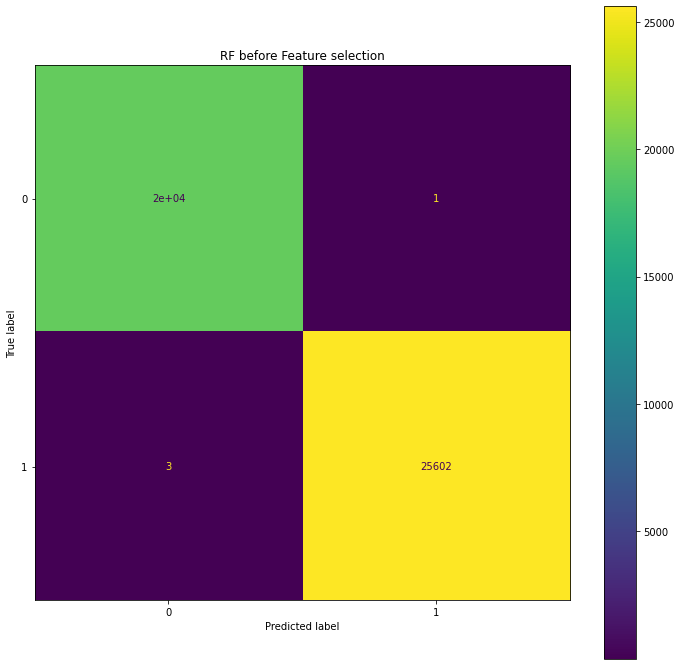

In [ ]:
# fourth the random forest classifier

rf_clf = RandomForestClassifier(random_state = 42, n_estimators=100, max_depth=None)

rf_clf.fit(X_train_cicids, y_train_cicids)

y_pred = rf_clf.predict(X_test_cicids)

print(classification_report(y_test_cicids, y_pred))

F1_RF = f1_score(y_test_cicids, y_pred)

cicids_fs_before.append(['RF', F1_RF])

evaluate_model(rf_clf, X_test_cicids, y_test_cicids, 'RF before Feature selection')

In [ ]:
cicids_fs_before

[['MLP', 0.9874599683605355],
 ['MLP', 0.9996094817823252],
 ['NB', 0.8937826487759911],
 ['SVM', 0.9981473897696913],
 ['RF', 0.9999218872051242]]

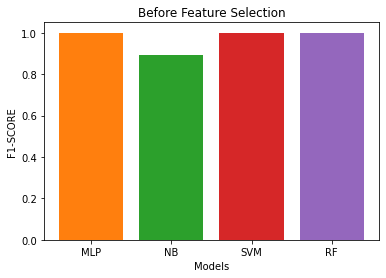

In [ ]:
plotModels(cicids_fs_before, 'Before Feature Selection', 'Models', 'F1-SCORE')

## Now using the Genetic Algorithm for feature selection

In [ ]:
initial_population_cicids = [[random.randint(0, 1) for i in range(78)] for i in range(20)]

In [ ]:
fittest_cicids = run_ga(initial_population, 10, num_of_features = 78,
                 X_train = X_train_cicids, y_train = y_train_cicids, X_test = X_test_cicids, y_test = y_test_cicids, mutation_rate = 5)   
# using default mutation which is one in each thousand

In [ ]:
%matplotlib inline
fitness_cicids = [ind[1] for ind in fittest_cicids]
sns.lineplot(y=fitness_cicids, x=range(20))

In [ ]:
for item in fittest_cicids[:-1]:
    if item[1] == max(fitness_cicids):
        top_performer_cicids = item
        break

In [ ]:
print("Total features included: " + str(top_performer[0].count(1)))

In [ ]:
included_columns_cicids = [column for (column, binary_value) in zip(X_train_cicids.columns, top_performer_cicids[0]) if binary_value]
excluded_columns_cicids = [column for (column, binary_value) in zip(X_train_cicids.columns, top_performer_cicids[0]) if not binary_value]

In [ ]:
included_columns_cicids 

In [ ]:
excluded_columns_cicids

## Feature Selection using Entropy

In [ ]:
cicids_temp = cicids_dataset
cicids_temp = cicids_temp.rename(columns={'Label': 'class'})
df_entropy_binary = get_entropy(cicids_temp)
print(df_entropy_binary)

                 feature    entropy
15        Flow Packets/s  16.943824
16         Flow IAT Mean  16.940865
14          Flow Bytes/s  16.937610
36         Fwd Packets/s  16.923648
1          Flow Duration  16.911879
..                   ...        ...
56    Fwd Avg Bytes/Bulk  -0.000000
57  Fwd Avg Packets/Bulk  -0.000000
58     Fwd Avg Bulk Rate  -0.000000
59    Bwd Avg Bytes/Bulk  -0.000000
78                 class  -0.000000

[79 rows x 2 columns]


In [ ]:
selected_features_df = df_entropy_binary.loc[df_entropy_binary['entropy'] > 0]
selected_features_df

,feature,entropy
15,Flow Packets/s,16.943824
16,Flow IAT Mean,16.940865
14,Flow Bytes/s,16.937610
36,Fwd Packets/s,16.923648
1,Flow Duration,16.911879
...,...,...
67,Init_Win_bytes_backward,0.945872
11,Bwd Packet Length Min,0.025201
43,FIN Flag Count,0.002880
0,Destination Port,0.000431


In [ ]:
selected_features = selected_features_df["feature"].tolist()
X_train_fs = X_train_cicids[selected_features]
X_test_fs = X_test_cicids[selected_features]

### Now, testing after applying feature selection

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19538
           1       1.00      1.00      1.00     25605

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143



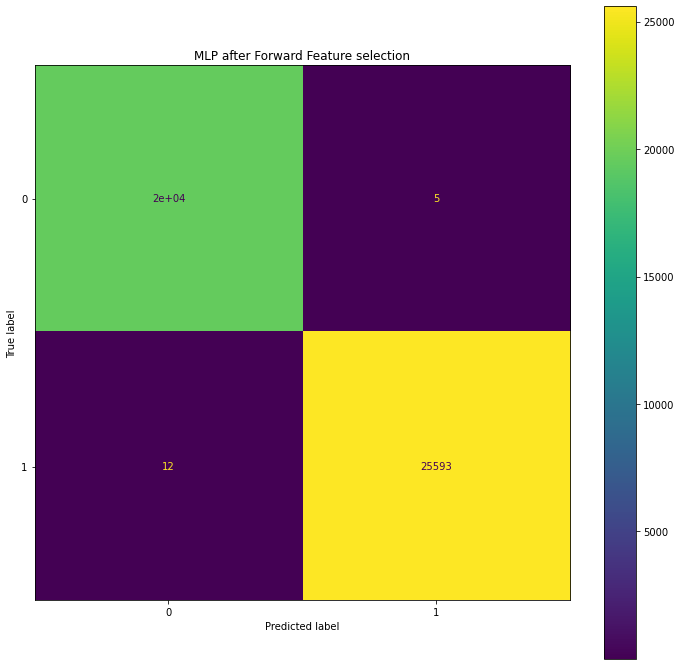

In [ ]:
# first the mlp classifier
after_fors=[]
mlp_clf = MLPClassifier(random_state = 42, max_iter = 1000, hidden_layer_sizes = (100, 200), alpha= 0.0001, solver='adam')

mlp_clf.fit(X_train_fs, y_train_cicids)

y_pred = mlp_clf.predict(X_test_fs)

print(classification_report(y_test_cicids, y_pred))

F1_mlp = f1_score(y_test_cicids, y_pred, average='weighted')
after_fors.append(['MLP', F1_mlp])

evaluate_model(mlp_clf, X_test_fs, y_test_cicids, 'MLP after Forward Feature selection')

              precision    recall  f1-score   support

           0       0.94      0.93      0.93     19538
           1       0.94      0.95      0.95     25605

    accuracy                           0.94     45143
   macro avg       0.94      0.94      0.94     45143
weighted avg       0.94      0.94      0.94     45143



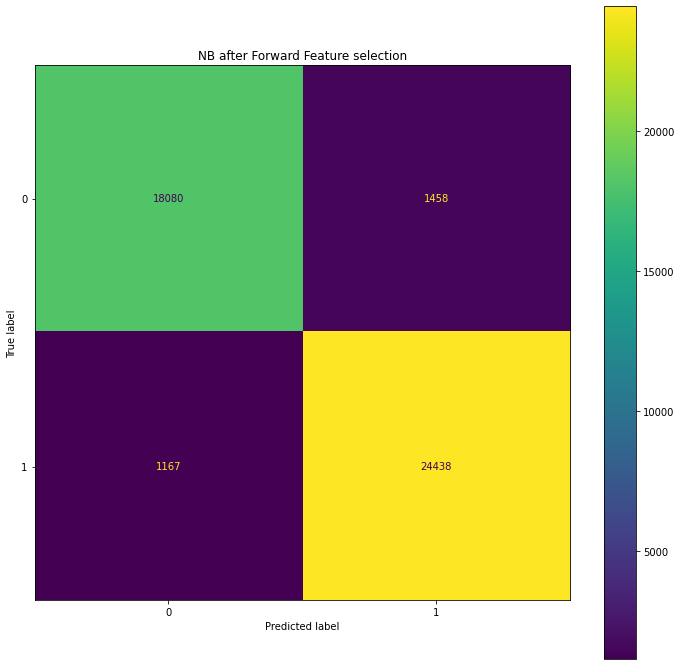

In [ ]:
# second the multinomial naive bayes

nb_clf = MultinomialNB()

nb_clf.fit(X_train_fs, y_train_cicids)

y_pred = nb_clf.predict(X_test_fs)

print(classification_report(y_test_cicids, y_pred))

evaluate_model(nb_clf, X_test_fs, y_test_cicids, 'NB after Forward Feature selection')

F1_NB = f1_score(y_test_cicids, y_pred, average='weighted')

after_fors.append(['NB', F1_NB])


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19538
           1       1.00      1.00      1.00     25605

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143



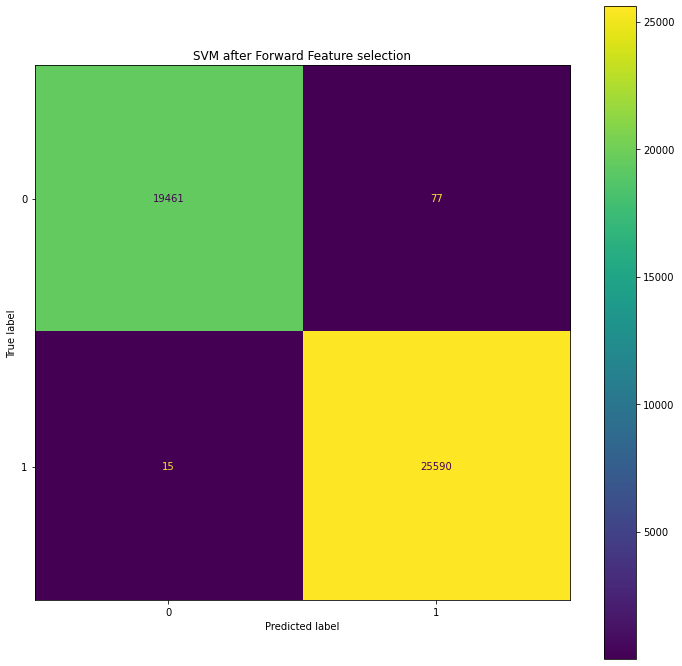

In [ ]:
# third the SVM model

svm_clf = SVC(random_state = 42, C=100, gamma=1)

svm_clf.fit(X_train_fs, y_train_cicids)

y_pred = svm_clf.predict(X_test_fs)

print(classification_report(y_test_cicids, y_pred))

F1_SVM = f1_score(y_test_cicids, y_pred, average='weighted')

after_fors.append(['SVM', F1_SVM])

evaluate_model(svm_clf, X_test_fs, y_test_cicids, 'SVM after Forward Feature selection')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19538
           1       1.00      1.00      1.00     25605

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143



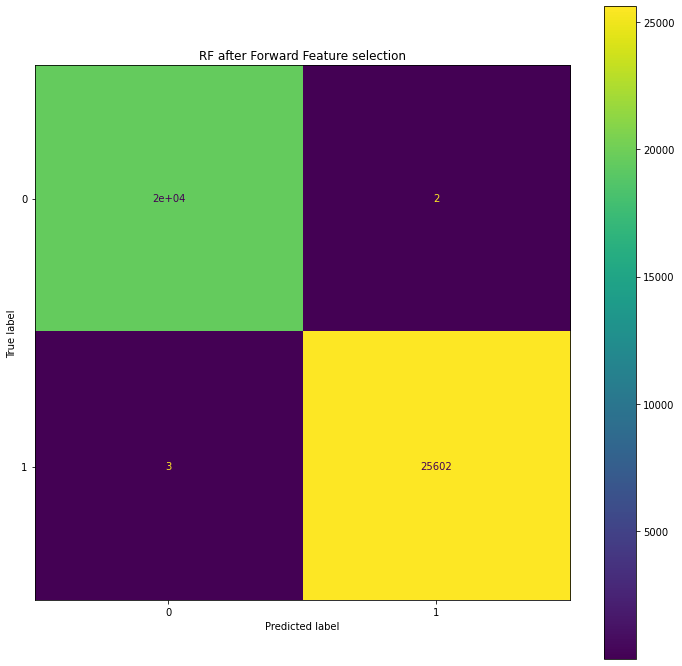

In [ ]:
# fourth the random forest classifier

rf_clf = RandomForestClassifier(random_state = 42, n_estimators=128, max_depth=None)

rf_clf.fit(X_train_fs, y_train_cicids)

y_pred = rf_clf.predict(X_test_fs)

print(classification_report(y_test_cicids, y_pred))

F1_RF = f1_score(y_test_cicids, y_pred, average='weighted')

after_fors.append(['RF', F1_RF])

evaluate_model(rf_clf, X_test_fs, y_test_cicids, 'RF after Forward Feature selection')

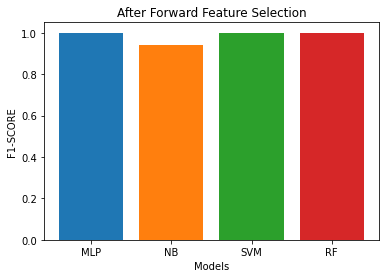

In [ ]:
plotModels(after_fors, 'After Forward Feature Selection', 'Models', 'F1-SCORE')

In [ ]:
after_fors

[['MLP', 0.9996234268958589],
 ['NB', 0.9417975890190812],
 ['SVM', 0.9979616446168639],
 ['RF', 0.9998892411925815]]

## Feature Selection using Forward Model Selection

In [ ]:
clfd = RandomForestClassifier(random_state=42)
sfs = SequentialFeatureSelector(clfd,
          n_features_to_select=10,
          direction='forward',
          n_jobs=-1,
          scoring='f1_weighted',
          cv=5)
# Build step forward feature selection
sfs1 = sfs.fit(X_train, y_train)
ss=[]
k=sfs.get_support()
for j in range(len(k)):
    if k[j]==True:
      ss.append(X_train.columns[j])

In [ ]:
ss

['Destination Port',
 'Flow Duration',
 'Total Backward Packets',
 'Total Length of Fwd Packets',
 'Fwd Packet Length Max',
 'Fwd Packet Length Std',
 'Bwd Packet Length Std',
 'Fwd IAT Total',
 'Fwd IAT Max',
 'Bwd IAT Total',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Bwd Header Length',
 'Init_Win_bytes_backward']

In [ ]:
#Here we save the extracted features to be used later as the previous cell takes time to run.
ss=['Destination Port', 'Flow Duration', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Std', 'Bwd Packet Length Std', 'Fwd IAT Total', 'Fwd IAT Max', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Bwd Header Length', 'Init_Win_bytes_backward']


### Now, testing after applying feature selection

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19538
           1       1.00      1.00      1.00     25605

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143



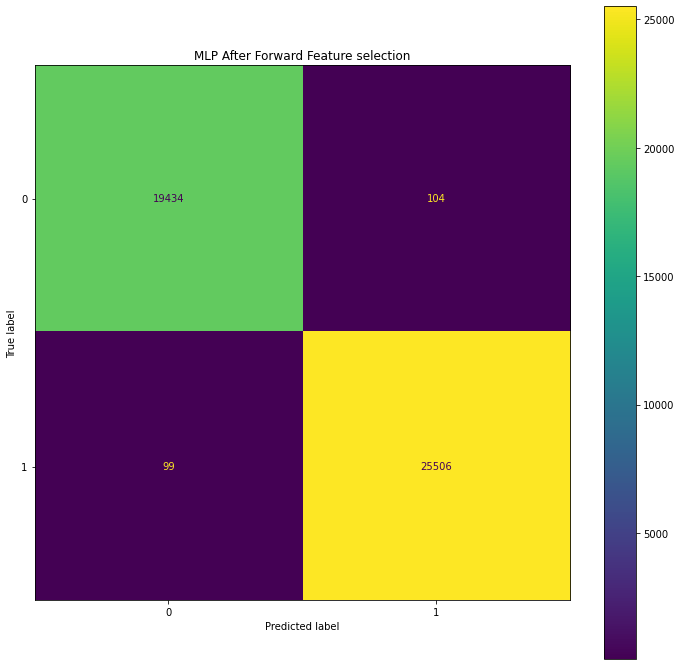

In [ ]:
# first the mlp classifier
cicids_fs_after=[]
mlp_clf = MLPClassifier(random_state = 42, max_iter = 100, hidden_layer_sizes = (100, ), alpha= 0.0001, solver='adam')

mlp_clf.fit(X_train_cicids[ss], y_train_cicids)

y_pred = mlp_clf.predict(X_test_cicids[ss])

print(classification_report(y_test_cicids, y_pred))

F1_mlp = f1_score(y_test_cicids, y_pred)

cicids_fs_after.append(['MLP', F1_mlp])

evaluate_model(mlp_clf, X_test_cicids[ss], y_test_cicids, 'MLP After Forward Feature selection')

              precision    recall  f1-score   support

           0       1.00      0.55      0.71     19538
           1       0.74      1.00      0.85     25605

    accuracy                           0.80     45143
   macro avg       0.87      0.77      0.78     45143
weighted avg       0.85      0.80      0.79     45143



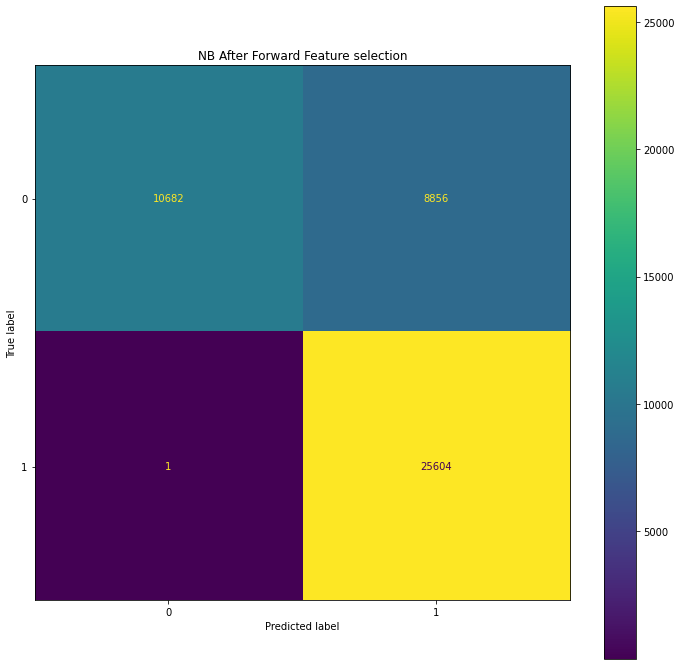

In [ ]:
# second the multinomial naive bayes

nb_clf = MultinomialNB()

nb_clf.fit(X_train_cicids[ss], y_train_cicids)

y_pred = nb_clf.predict(X_test_cicids[ss])

print(classification_report(y_test_cicids, y_pred))


evaluate_model(nb_clf, X_test_cicids[ss], y_test_cicids, 'NB After Forward Feature selection')

F1_NB = f1_score(y_test_cicids, y_pred)

cicids_fs_after.append(['NB', F1_NB])

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19538
           1       1.00      0.98      0.99     25605

    accuracy                           0.99     45143
   macro avg       0.99      0.99      0.99     45143
weighted avg       0.99      0.99      0.99     45143



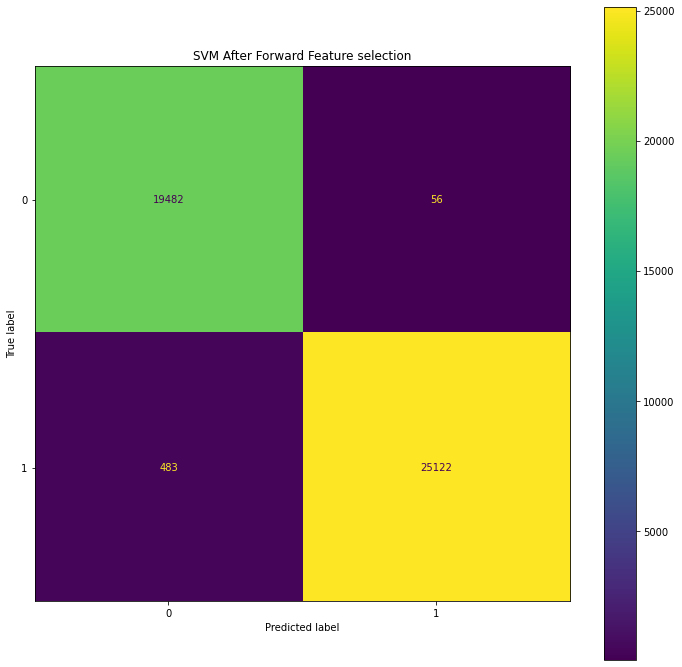

In [ ]:
# third the SVM model

svm_clf = SVC(random_state = 42, C=100, gamma=1)

svm_clf.fit(X_train_cicids[ss], y_train_cicids)

y_pred = svm_clf.predict(X_test_cicids[ss])

print(classification_report(y_test_cicids, y_pred))

F1_SVM = f1_score(y_test_cicids, y_pred)

cicids_fs_after.append(['SVM', F1_SVM])

evaluate_model(svm_clf, X_test_cicids[ss], y_test_cicids, 'SVM After Forward Feature selection')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19538
           1       1.00      1.00      1.00     25605

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143



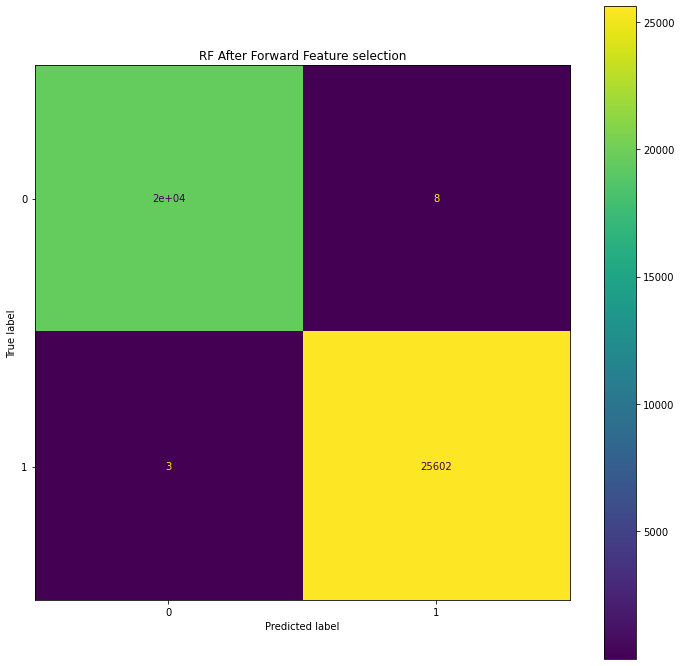

In [ ]:
# fourth the random forest classifier

rf_clf = RandomForestClassifier(random_state = 42, n_estimators=100, max_depth=None)

rf_clf.fit(X_train_cicids[ss], y_train_cicids)

y_pred = rf_clf.predict(X_test_cicids[ss])

print(classification_report(y_test_cicids, y_pred))

F1_RF = f1_score(y_test_cicids, y_pred)

cicids_fs_after.append(['RF', F1_RF])

evaluate_model(rf_clf, X_test_cicids[ss], y_test_cicids, 'RF After Forward Feature selection')

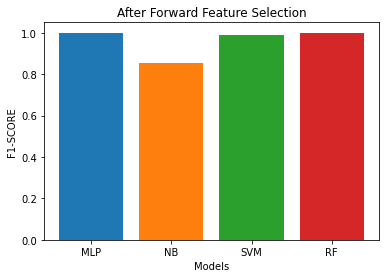

In [ ]:
plotModels(cicids_fs_after, 'After Forward Feature Selection', 'Models', 'F1-SCORE')

In [ ]:
cicids_fs_after

[['MLP', 0.9960363174851118],
 ['NB', 0.8525430783318072],
 ['SVM', 0.9893862119213123],
 ['RF', 0.9997852191740701]]

## Feature Selection using Embedded Methods

In [ ]:
rfe_features = []

In [ ]:
#Recursive Feature Elimination
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LassoCV

rfe = RFECV(estimator=LassoCV(), cv=5, n_jobs=-1)
# fit the model
fitted_model = rfe.fit(X_train_cicids, y_train_cicids)

In [ ]:
print('Optimal number of features: {}'.format(fitted_model.n_features_))

Optimal number of features: 32


In [ ]:
dataframe = []
rfe_selected_features = []
for i in range(X_train_cicids.shape[1]):
  if(fitted_model.support_[i] == True):
    dataframe.append([X_train_cicids.columns[i], fitted_model.ranking_[i], fitted_model.support_[i]])
    rfe_selected_features.append(X_train_cicids.columns[i])

pd.DataFrame(dataframe, columns=['Feature', 'ranking', 'selected'])

,Feature,ranking,selected
0,Destination Port,1,True
1,Flow Duration,1,True
2,Fwd Packet Length Max,1,True
3,Fwd Packet Length Min,1,True
4,Fwd Packet Length Mean,1,True
5,Bwd Packet Length Min,1,True
6,Flow IAT Mean,1,True
7,Flow IAT Std,1,True
8,Flow IAT Max,1,True
9,Fwd IAT Std,1,True


In [ ]:
rfe_selected_features

['Destination Port',
 'Flow Duration',
 'Fwd Packet Length Max',
 'Fwd Packet Length Min',
 'Fwd Packet Length Mean',
 'Bwd Packet Length Min',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Fwd IAT Std',
 'Bwd IAT Total',
 'Bwd IAT Mean',
 'Bwd IAT Max',
 'Fwd PSH Flags',
 'Fwd Packets/s',
 'Min Packet Length',
 'Packet Length Mean',
 'Packet Length Std',
 'Packet Length Variance',
 'FIN Flag Count',
 'PSH Flag Count',
 'ACK Flag Count',
 'URG Flag Count',
 'Average Packet Size',
 'Avg Fwd Segment Size',
 'Avg Bwd Segment Size',
 'Init_Win_bytes_forward',
 'Init_Win_bytes_backward',
 'min_seg_size_forward',
 'Idle Mean',
 'Idle Std',
 'Idle Max']

### Now, testing after applying feature selection

In [ ]:
rfe_features = []
new_X_train = X_train_cicids[rfe_selected_features]
print('new shape', new_X_train.shape)
new_X_test = X_test_cicids[rfe_selected_features]

new shape (162511, 32)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19538
           1       1.00      1.00      1.00     25605

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143



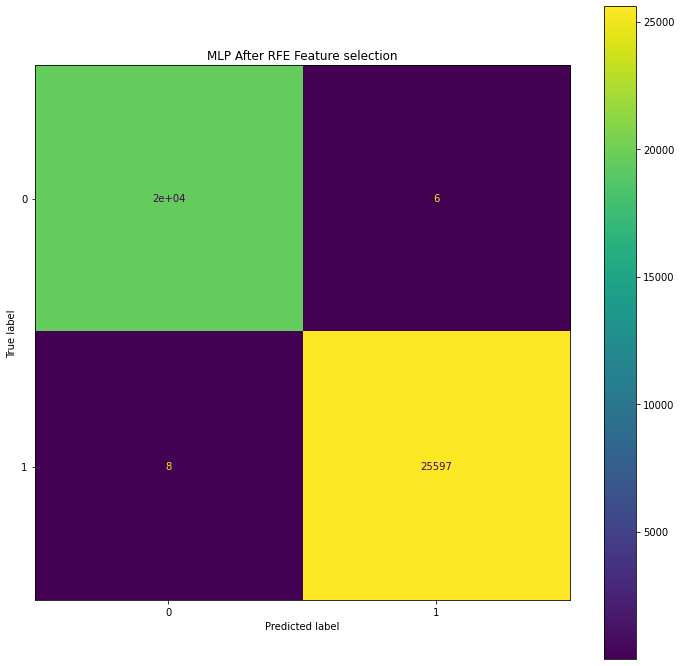

In [ ]:
# first the mlp classifier

mlp_clf = MLPClassifier(random_state = 42, max_iter = 1000, hidden_layer_sizes = (100, 200), alpha= 0.0001, solver='adam')

mlp_clf.fit(new_X_train, y_train_cicids)

y_pred = mlp_clf.predict(new_X_test)

print(classification_report(y_test_cicids, y_pred))

F1_mlp = f1_score(y_test_cicids, y_pred, average='weighted')
rfe_features.append(['MLP', F1_mlp])

evaluate_model(mlp_clf, new_X_test, y_test_cicids, 'MLP After RFE Feature selection')

              precision    recall  f1-score   support

           0       1.00      0.87      0.93     19538
           1       0.91      1.00      0.95     25605

    accuracy                           0.94     45143
   macro avg       0.96      0.94      0.94     45143
weighted avg       0.95      0.94      0.94     45143



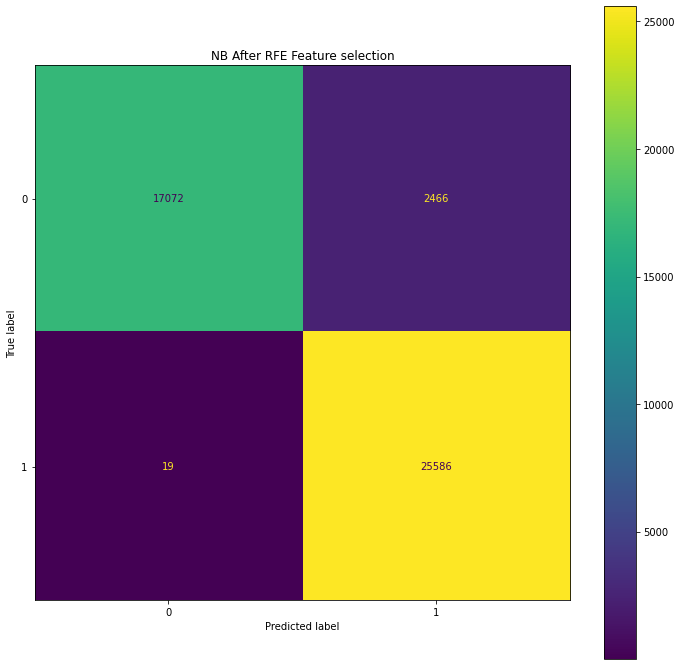

In [ ]:
# second the multinomial naive bayes

nb_clf = MultinomialNB()

nb_clf.fit(new_X_train, y_train_cicids)

y_pred = nb_clf.predict(new_X_test)

print(classification_report(y_test_cicids, y_pred))

evaluate_model(nb_clf, new_X_test, y_test_cicids, 'NB After RFE Feature selection')

F1_NB = f1_score(y_test_cicids, y_pred, average='weighted')

rfe_features.append(['NB', F1_NB])


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19538
           1       0.99      1.00      1.00     25605

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143



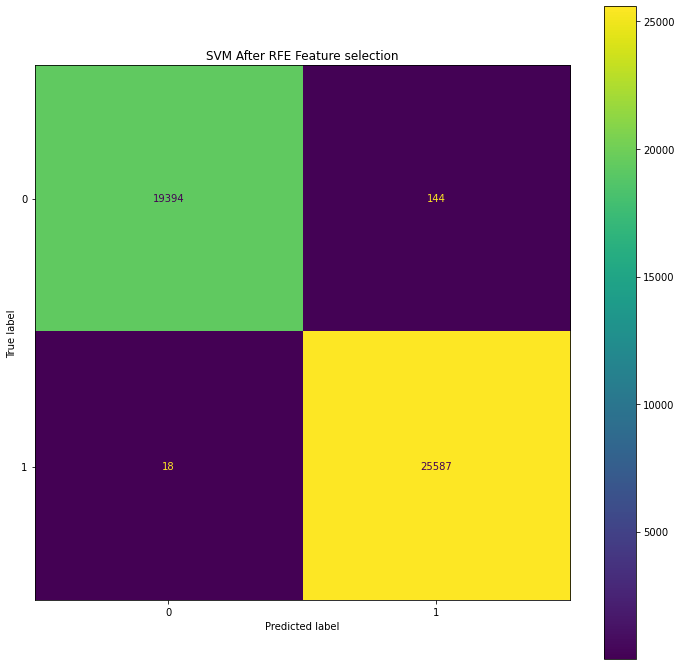

In [ ]:
# third the SVM model

svm_clf = SVC(random_state = 42, C=100, gamma=1)

svm_clf.fit(new_X_train, y_train_cicids)

y_pred = svm_clf.predict(new_X_test)

print(classification_report(y_test_cicids, y_pred))

F1_SVM = f1_score(y_test_cicids, y_pred, average='weighted')

rfe_features.append(['SVM', F1_SVM])

evaluate_model(svm_clf, new_X_test, y_test_cicids, 'SVM After RFE Feature selection')


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19538
           1       1.00      1.00      1.00     25605

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143



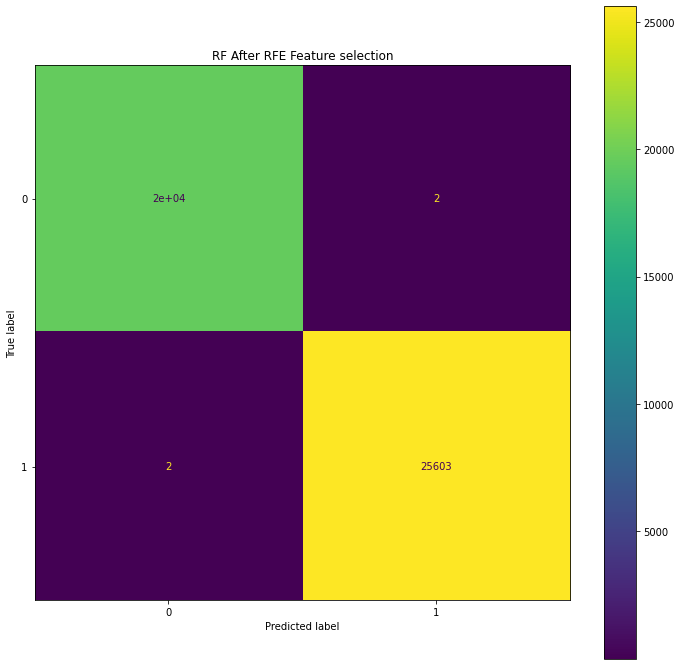

In [ ]:
# fourth the random forest classifier

rf_clf = RandomForestClassifier(random_state = 42, n_estimators=128, max_depth=None)

rf_clf.fit(new_X_train, y_train_cicids)

y_pred = rf_clf.predict(new_X_test)

print(classification_report(y_test_cicids, y_pred))

F1_RF = f1_score(y_test_cicids, y_pred, average='weighted')

rfe_features.append(['RF', F1_RF])

evaluate_model(rf_clf, new_X_test, y_test_cicids, 'RF After RFE Feature selection')


In [ ]:
rfe_features

[['MLP', 0.9996898762790036],
 ['NB', 0.9443691906884939],
 ['SVM', 0.996410003314197],
 ['RF', 0.9999113926854661]]

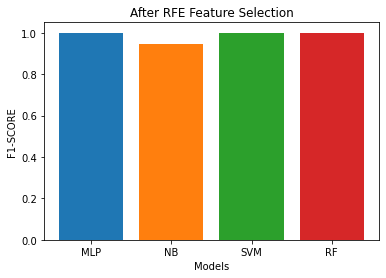

In [ ]:
plotModels(rfe_features, 'After RFE Feature Selection', 'Models', 'F1-SCORE')

## New Ensemble Feature selection

In [ ]:
def ensemble_method(no_features, s1, s2, s3):
  s11=set(s1)
  s22=set(s2)
  s33=set(s3)

  set1 = s11.intersection(s22) 
  set2 = set1.intersection(s33)


  # Converts resulting set to list
  feature=list(set2)
  
  while len(feature) <= no_features:
    for item in set1:
      if item not in feature:
            feature.append(item)
      
    for item in s11.intersection(s33):
      if item not in feature:
        feature.append(item)
    
    for item in s22.intersection(s33):
      if item not in feature:
        feature.append(item)

  print(feature)
  print(len(feature))
  
  return feature

In [ ]:
#s1,s2, and s3 are the extracted features from each feature selection method. They were added manually here in order to not run the entire notebook
# from the beginning
s1=['Destination Port', 'Flow Duration', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Std', 'Bwd Packet Length Std', 'Fwd IAT Total', 'Fwd IAT Max', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Bwd Header Length', 'Init_Win_bytes_backward']
s2=['Flow Packets/s',
 'Flow IAT Mean',
 'Flow Bytes/s',
 'Fwd Packets/s',
 'Flow Duration',
 'Flow IAT Std',
 'Flow IAT Max',
 'Fwd IAT Std',
 'Fwd IAT Mean',
 'Fwd IAT Max',
 'Fwd IAT Total',
 'Bwd Packets/s',
 'Bwd IAT Std',
 'Bwd IAT Mean',
 'Bwd IAT Total',
 'Bwd IAT Max',
 'Fwd IAT Min',
 'Idle Min',
 'Idle Max',
 'Idle Mean',
 'Active Min',
 'Active Max',
 'Active Mean',
 'Flow IAT Min',
 'Bwd IAT Min',
 'Packet Length Std',
 'Packet Length Variance',
 'Bwd Packet Length Std',
 'Average Packet Size',
 'Packet Length Mean',
 'Bwd Packet Length Max',
 'Max Packet Length',
 'Avg Bwd Segment Size',
 'Bwd Packet Length Mean',
 'Fwd Header Length.1',
 'Fwd Header Length',
 'Total Length of Fwd Packets',
 'Subflow Fwd Bytes',
 'Subflow Fwd Packets',
 'Total Fwd Packets',
 'act_data_pkt_fwd',
 'Bwd Header Length',
 'Subflow Bwd Packets',
 'Total Backward Packets',
 'Fwd Packet Length Std',
 'Fwd Packet Length Mean',
 'Avg Fwd Segment Size',
 'Subflow Bwd Bytes',
 'Total Length of Bwd Packets',
 'Down/Up Ratio',
 'Idle Std',
 'Init_Win_bytes_forward',
 'PSH Flag Count',
 'ACK Flag Count',
 'Fwd Packet Length Max',
 'Fwd Packet Length Min',
 'Min Packet Length',
 'Init_Win_bytes_backward',
 'Bwd Packet Length Min',
 'FIN Flag Count',
 'Destination Port',
 'URG Flag Count']
s3=['Destination Port',
 'Flow Duration',
 'Fwd Packet Length Max',
 'Fwd Packet Length Min',
 'Fwd Packet Length Mean',
 'Bwd Packet Length Min',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Fwd IAT Std',
 'Bwd IAT Total',
 'Bwd IAT Mean',
 'Bwd IAT Max',
 'Fwd PSH Flags',
 'Fwd Packets/s',
 'Min Packet Length',
 'Packet Length Mean',
 'Packet Length Std',
 'Packet Length Variance',
 'FIN Flag Count',
 'PSH Flag Count',
 'ACK Flag Count',
 'URG Flag Count',
 'Average Packet Size',
 'Avg Fwd Segment Size',
 'Avg Bwd Segment Size',
 'Init_Win_bytes_forward',
 'Init_Win_bytes_backward',
 'min_seg_size_forward',
 'Idle Mean',
 'Idle Std',
 'Idle Max']

feature2 = ensemble_method(40, s1, s2, s3)

20
['Init_Win_bytes_backward', 'Bwd IAT Max', 'Destination Port', 'Bwd IAT Total', 'Fwd Packet Length Max', 'Bwd IAT Mean', 'Flow Duration', 'Bwd IAT Std', 'Fwd Packet Length Std', 'Total Length of Fwd Packets', 'Bwd Header Length', 'Bwd IAT Min', 'Total Backward Packets', 'Fwd IAT Total', 'Fwd IAT Max', 'Bwd Packet Length Std', 'Fwd PSH Flags', 'Avg Bwd Segment Size', 'Idle Mean', 'Fwd IAT Std', 'Idle Std', 'Packet Length Std', 'Packet Length Variance', 'Flow IAT Max', 'Min Packet Length', 'FIN Flag Count', 'URG Flag Count', 'PSH Flag Count', 'Packet Length Mean', 'Fwd Packets/s', 'Average Packet Size', 'ACK Flag Count', 'Avg Fwd Segment Size', 'Flow IAT Mean', 'Flow IAT Std', 'Init_Win_bytes_forward', 'Fwd Packet Length Min', 'Bwd Packet Length Min', 'Fwd Packet Length Mean', 'Idle Max']
40


In [ ]:
rfe_features2 = []
new_X_train = X_train_cicids[feature2]
print('new shape', new_X_train.shape)
new_X_test = X_test_cicids[feature2]

new shape (162511, 40)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19538
           1       1.00      1.00      1.00     25605

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143



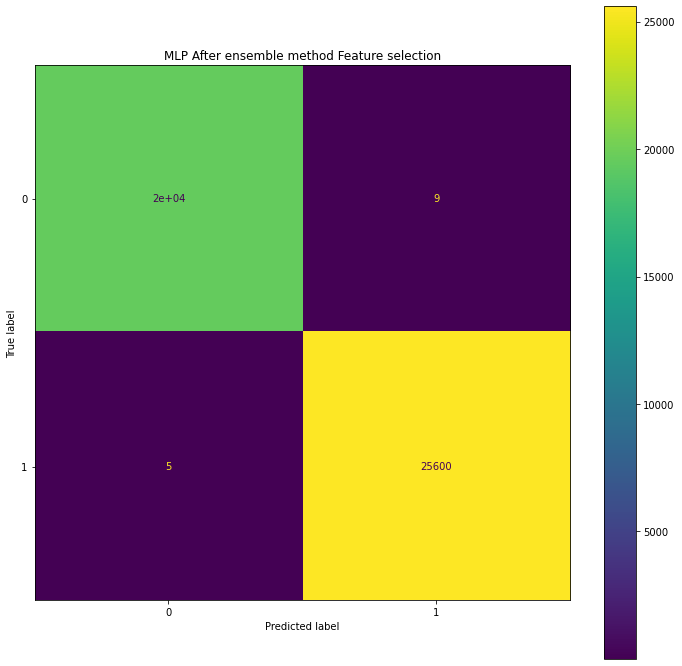

In [ ]:
# first the mlp classifier

mlp_clf = MLPClassifier(random_state = 42, max_iter = 100, hidden_layer_sizes = (100, 200), alpha= 0.0001, solver='adam')

mlp_clf.fit(new_X_train, y_train_cicids)

y_pred = mlp_clf.predict(new_X_test)

print(classification_report(y_test_cicids, y_pred))

F1_mlp = f1_score(y_test_cicids, y_pred, average='weighted')
rfe_features2.append(['MLP', F1_mlp])

evaluate_model(mlp_clf, new_X_test, y_test_cicids, 'MLP After ensemble method Feature selection')

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     19538
           1       0.92      1.00      0.96     25605

    accuracy                           0.95     45143
   macro avg       0.96      0.94      0.95     45143
weighted avg       0.95      0.95      0.95     45143



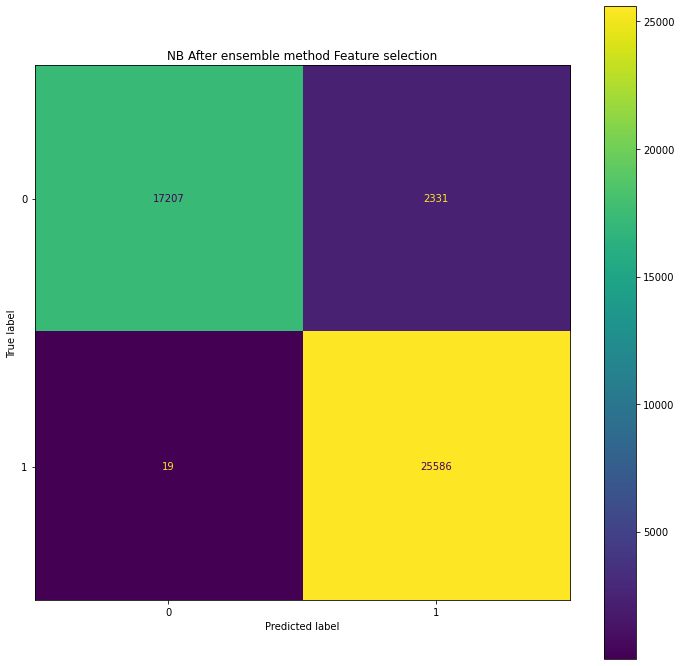

In [ ]:
# second the multinomial naive bayes

nb_clf = MultinomialNB()

nb_clf.fit(new_X_train, y_train_cicids)

y_pred = nb_clf.predict(new_X_test)

print(classification_report(y_test_cicids, y_pred))

evaluate_model(nb_clf, new_X_test, y_test_cicids, 'NB After ensemble method Feature selection')

F1_NB = f1_score(y_test_cicids, y_pred, average='weighted')

rfe_features2.append(['NB', F1_NB])


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     19538
           1       0.99      1.00      1.00     25605

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143



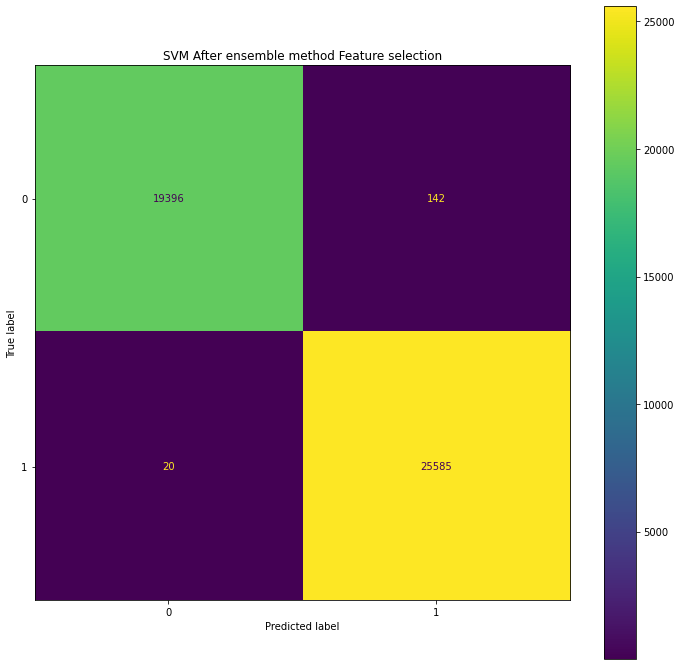

In [ ]:
# third the SVM model

svm_clf = SVC(random_state = 42, C=100, gamma=1)

svm_clf.fit(new_X_train, y_train_cicids)

y_pred = svm_clf.predict(new_X_test)

print(classification_report(y_test_cicids, y_pred))

F1_SVM = f1_score(y_test_cicids, y_pred, average='weighted')

rfe_features2.append(['SVM', F1_SVM])

evaluate_model(svm_clf, new_X_test, y_test_cicids, 'SVM After ensemble method Feature selection')


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19538
           1       1.00      1.00      1.00     25605

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143



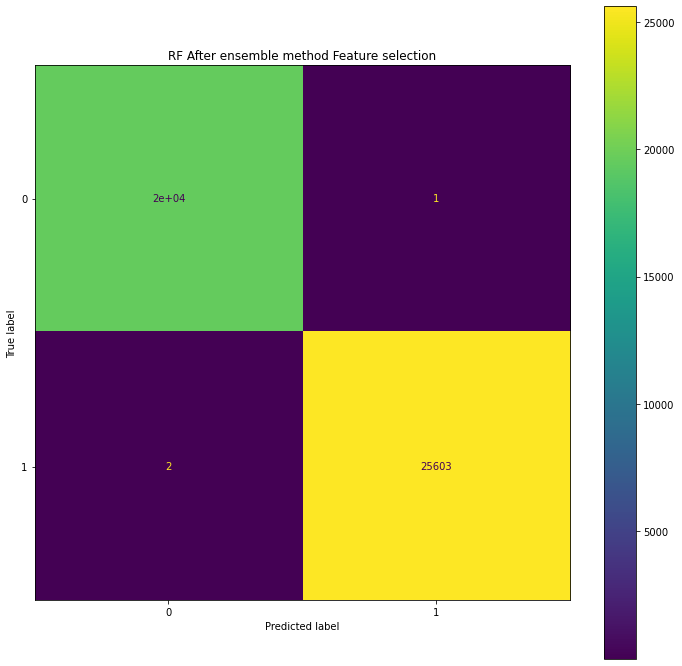

In [ ]:
# fourth the random forest classifier

rf_clf = RandomForestClassifier(random_state = 42, n_estimators=128, max_depth=None)

rf_clf.fit(new_X_train, y_train_cicids)

y_pred = rf_clf.predict(new_X_test)

print(classification_report(y_test_cicids, y_pred))

F1_RF = f1_score(y_test_cicids, y_pred, average='weighted')

rfe_features2.append(['RF', F1_RF])

evaluate_model(rf_clf, new_X_test, y_test_cicids, 'RF After ensemble method Feature selection')


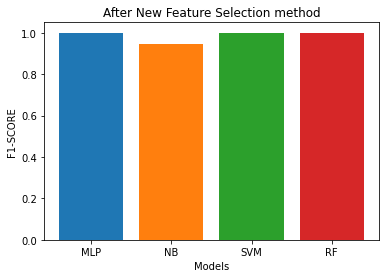

In [ ]:
plotModels(rfe_features2, 'After New Feature Selection method', 'Models', 'F1-SCORE')

In [ ]:
print('F1 score for each model was:')
rfe_features2


F1 score for each model was:


[['MLP', 0.9996898706355312],
 ['NB', 0.9474306926751823],
 ['SVM', 0.996410048682223],
 ['RF', 0.9999335447155488]]